## Example 1

This example uses the Wikipedia conversations corpus to test the coordination between editors and admins on Wikipedia:

- Do speakers on the whole coordinate more to admins or nonadmins?
- Do admins coordinate to other people more than nonadmins do?

The plots correspond to those in Figure 1 in the [Echoes of Power paper](https://www.cs.cornell.edu/~cristian/Echoes_of_power.html). The code is not the same as the original, so some discrepancies might occur.

In [1]:
from convokit import Utterance, Corpus, Coordination, download

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

%matplotlib inline

In [2]:
# OPTION 1: DOWNLOAD CORPUS
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# ROOT_DIR = convokit.download('wiki-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE CORPUS IS LOCATED
# ROOT_DIR = '<YOUR DIRECTORY>'

corpus = Corpus(ROOT_DIR)

In [3]:
# helper function to plot two coordination scores against each other as a chart,
#   on aggregate and by coordination marker
# a is a tuple (speakers, targets)
# b is a tuple (speakers, targets)
def make_chart(a_scores, b_scores, a_description, b_description, a_color="b", b_color="g"):
    # get scores by marker and on aggregate
    a_score_by_marker = a_scores["marker_agg2"]
    a_agg1, a_agg2, a_agg3 = a_scores["agg1"], a_scores["agg2"], a_scores["agg3"]
    b_score_by_marker = b_scores["marker_agg2"]
    b_agg1, b_agg2, b_agg3 = b_scores["agg1"], b_scores["agg2"], b_scores["agg3"]

    # the rest plots this data as a double bar graph
    a_data_points = sorted(a_score_by_marker.items())
    b_data_points = sorted(b_score_by_marker.items())
    a_data_points, b_data_points = zip(*sorted(zip(a_data_points, b_data_points),
        key=lambda x: x[0][1], reverse=True))
    labels, a_data_points = zip(*a_data_points)
    _, b_data_points = zip(*b_data_points)

    labels = ["aggregate 1", "aggregate 2", "aggregate 3"] + list(labels)
    a_data_points = [a_agg1, a_agg2, a_agg3] + list(a_data_points)
    b_data_points = [b_agg1, b_agg2, b_agg3] + list(b_data_points)

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(a_data_points)) + 0.35)
    ax.set_xticklabels(labels, rotation="vertical")

    ax.bar(np.arange(len(a_data_points)), a_data_points, 0.35, color=a_color)
    ax.bar(np.arange(len(b_data_points)) + 0.35, b_data_points, 0.35, color=b_color)

    b_patch = mpatches.Patch(color="b",
                             label=a_description + " (total: " +
                             str(a_scores["count_agg1"]) + ", " +
                             str(a_scores["count_agg2"]) + ")")
    g_patch = mpatches.Patch(color="g",
                             label=b_description + " (total: "  +
                             str(b_scores["count_agg1"]) + ", " +
                             str(b_scores["count_agg2"]) + ")")
    plt.legend(handles=[b_patch, g_patch])

    filename = str(a_description) + " vs " + str(b_description) + ".png"
    plt.savefig(filename, bbox_inches="tight")
    print('Created chart "' + filename + '"')

In [ ]:
# create coordination object
coord = Coordination()
coord.fit(corpus)

# get all groups of speakers that we want to compare
everyone = lambda speaker: True
admins = lambda speaker: speaker.meta["is-admin"]
nonadmins = lambda speaker: not speaker.meta["is-admin"]
split = ["is-admin"]

# do speakers on the whole coordinate more to admins or nonadmins?
make_chart(
    coord.summarize(corpus, everyone, admins, focus="targets", summary_report=True,
                    target_thresh=7, split_by_attribs=split),
    coord.summarize(corpus, everyone, nonadmins, focus="targets", summary_report=True,
                    target_thresh=7, split_by_attribs=split),
    "Target-admins", "Target-nonadmins"
)
# do admins coordinate to other people more than nonadmins do?
make_chart(
    coord.summarize(corpus, admins, everyone, summary_report=True,
                    speaker_thresh=7, target_thresh=7, split_by_attribs=split),
    coord.summarize(corpus, nonadmins, everyone, summary_report=True,
                    speaker_thresh=7, target_thresh=7, split_by_attribs=split),
    "Speaker-admins", "Speaker-nonadmins"
)

## Example 2

This example uses the [Supreme Court Oral Arguments corpus](https://convokit.cornell.edu/documentation/oyez.html) to compute some simple information:
- Which justices coordinate the most to others?
- Which justices are coordinated to the most?

In [1]:
import convokit

from convokit import Corpus

In [ ]:
# OPTION 1: DOWNLOAD CORPUS
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# ROOT_DIR = convokit.download('supreme-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE CORPUS IS LOCATED
# ROOT_DIR = '<YOUR DIRECTORY>'

corpus = Corpus(ROOT_DIR)

In [7]:
# compute coordination scores on this corpus
coord = convokit.Coordination()
coord.fit(corpus)

# get coordination scores
coord.transform(corpus)

# get set of all justices
justices = lambda speaker: speaker.meta["type"] == "J"
# get set of all speakers
everyone = lambda speaker: True

# compute coordination from each justice to everyone
print("Justices, ranked by how much they coordinate to others:")
justices_to_everyone = coord.summarize(corpus, justices, everyone)
for justice, score in sorted(justices_to_everyone.averages_by_speaker().items(),
    key=lambda x: x[1], reverse=True):
    print(justice.id, round(score, 5))
print()

# compute coordination from everyone to each justice
print("Justices, ranked by how much others coordinate to them:")
everyone_to_justices = coord.summarize(corpus, everyone, justices, focus="targets")
for justice, score in sorted(everyone_to_justices.averages_by_speaker().items(), 
    key=lambda x: x[1], reverse=True):
    print(justice.id, round(score, 5))
print()

Justices, ranked by how much they coordinate to others:
j__sandra_day_oconnor 0.04285
j__david_h_souter 0.04059
j__antonin_scalia 0.03841
j__potter_stewart 0.03784
j__stephen_g_breyer 0.03635
j__john_paul_stevens 0.03552
j__anthony_m_kennedy 0.03482
j__john_m_harlan 0.0342
j__samuel_a_alito_jr 0.03338
j__thurgood_marshall 0.0327
j__byron_r_white 0.0325
j__felix_frankfurter 0.03209
j__william_j_brennan_jr 0.03155
j__william_o_douglas 0.03002
j__stanley_reed 0.02947
j__john_m_harlan2 0.0283
j__hugo_l_black 0.02711
j__lewis_f_powell_jr 0.02566
j__abe_fortas 0.02558
j__harold_burton 0.02521
j__ruth_bader_ginsburg 0.02515
j__harry_a_blackmun 0.023
j__william_h_rehnquist 0.02291
j__elena_kagan 0.02244
j__tom_c_clark 0.02083
j__earl_warren 0.01949
j__sonia_sotomayor 0.01784
j__warren_e_burger 0.0166
j__charles_e_whittaker 0.01272
j__neil_gorsuch 0.01266
j__john_g_roberts_jr 0.01147
j__sherman_minton 0.01097
j__brett_m_kavanaugh 0.01032
j__arthur_j_goldberg 0.00864
j__clarence_thomas -0.00061


## Example 3

This example uses the Supreme Court Oral Argument Corpus to answer these questions:
- Do lawyers coordinate more to unfavorable (i.e., justices that eventually vote against their case) or favorable justices? 
- When talking to lawyers, do unfavorable or favorable justices coordinate more?

The plots correspond to Figures 4 and 5 in the [Echoes of Power paper](https://www.cs.cornell.edu/~cristian/Echoes_of_power.html). For this example, we use only the oral arguments for the court cases analyzed in the original paper. The code and the data are not identical with the ones originally used in the paper, so some discrepancies might occur.

In [9]:
case_ids = {'03-1164', '04-1332', '04-1140', '04-805', '04-1495', '05-352', '04-1360b', '06-5306', '03-1388', '04-473b', '03-8661', '03-1160', '03-633', '05-1508', '05-746', '05-547', '05-502', '04-759', '03-1116', '05-1240', '03-287', '04-607', '05-1126', '04-1477', '04-8990', '06-480', '04-1152', '05-1429', '03-1488', '04-10566', '04-905', '05-493', '05-1575', '04-848', '05-983', '03-1395', '06-5754', '04-52', '05-9264', '03-725', '05-184', '04-1131', '04-698', '05-381', '06-593', '02-1472', '04-712', '04-1376', '03-184', '06-116', '04-1618', '03-1500', '03-9627', '05-669', '05-85', '05-7058', '06-313', '05-1631', '05-6551', '04-1244', '05-705', '06-84', '03-1693', '04-593', '04-1034', '04-944', '04-1186', '05-1342', '04-277', '04-37', '04-70', '06-219', '04-1329', '05-465', '05-595', '04-631', '03-1230', '06-278', '04-473', '05-130', '03-814', '04-1414', '04-433', '05-83', '04-637', '04-1327', '03-9685', '02-1672', '03-1696', '04-1170b', '03-636', '04-1371', '05-1272', '04-6964', '05-380', '05-996', '03-1407', '05-1256', '05-998', '03-932', '06-5247', '04-1067', '05-1157', '03-923', '05-1541', '05-9222', '05-5992', '03-9168', '05-200', '05-260', '04-368', '04-603', '05-204', '04-480', '04-1528', '04-721', '03-10198', '04-495', '03-878', '03-9877', '04-1527', '05-593', '04-1506', '05-128', '06-5618', '05-1074', '03-9560', '03-892', '04-1084', '04-980', '05-7053', '04-881', '03-1237', '04-1324', '05-416', '04-5928', '05-1629', '04-5293', '03-9046', '04-163', '05-5705', '03-1293', '04-1581', '04-597', '04-169', '03-1423', '03-407', '03-750', '05-1056', '03-388', '05-5224', '03-931', '03-1238', '04-1203', '03-1454', '05-259', '05-11284', '05-8820', '05-608', '04-1739', '06-102', '04-5462', '03-855', '03-1039', '04-514', '04-563', '05-11304', '05-8794', '04-623', '04-885', '04-1170', '05-1589', '04-9728', '06-157', '04-5286', '04-1264', '05-908', '04-1704', '05-848', '04-1350', '05-1120', '03-409', '06-484', '04-1144', '05-785', '03-1601', '04-6432', '04-373', '04-1544', '04-278', '05-409', '05-5966', '04-928', '05-1382', '05-915', '05-1345', '128orig', '04-340', '03-1566', '05-18', '105original', '03-9659', '04-1360', '03-710'}

corpus = corpus.filter_utterances_by(lambda u: u.meta["case_id"][5:] in case_ids)

Created chart "Target-unfavorable justice vs Target-favorable justice.png"
Created chart "Speaker-unfavorable justice vs Speaker-favorable justice.png"


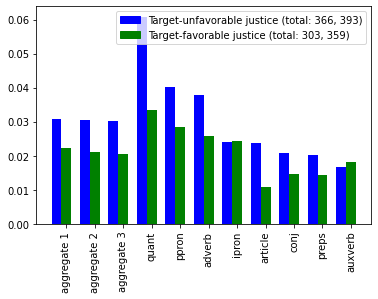

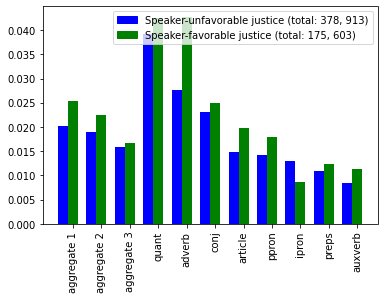

In [10]:
# split speakers by case id
# this treats the same person across two different cases as two different speakers
split = ["case_id"]

# create coordination object
coord = Coordination()
coord.fit(corpus)

# get all groups of speakers that we want to compare
everyone = lambda speaker: True
justices = lambda speaker: speaker.meta["type"] == "J"
lawyers = lambda speaker: speaker.meta["type"] == "A"

# filter out justice utterances, leaving only justices who voted on the same side as the advocates speaking to them
def target_justice_is_favorable(speaker_utt, target_utt):
    convo = speaker_utt.get_conversation()
    if convo.meta["votes_side"] is None: return False
    if speaker_utt.speaker.id not in convo.meta["advocates"]: return False
    lawyer_side = convo.meta["advocates"][speaker_utt.speaker.id]["side"]
    if target_utt.speaker.id not in convo.meta["votes_side"]: return False
    justice_side = convo.meta["votes_side"][target_utt.speaker.id]
    return justice_side == lawyer_side

def target_justice_is_unfavorable(speaker_utt, target_utt):
    convo = speaker_utt.get_conversation()
    if convo.meta["votes_side"] is None: return False
    if speaker_utt.speaker.id not in convo.meta["advocates"]: return False
    lawyer_side = convo.meta["advocates"][speaker_utt.speaker.id]["side"]
    if target_utt.speaker.id not in convo.meta["votes_side"]: return False
    justice_side = convo.meta["votes_side"][target_utt.speaker.id]
    return justice_side != lawyer_side

# filter out justice utterances, leaving only justices who voted on the same side as the advocates they spoke to
def speaker_justice_is_favorable(speaker_utt, target_utt):
    convo = speaker_utt.get_conversation()
    if convo.meta["votes_side"] is None: return False
    if target_utt.speaker.id not in convo.meta["advocates"]: return False
    lawyer_side = convo.meta["advocates"][target_utt.speaker.id]["side"]
    if speaker_utt.speaker.id not in convo.meta["votes_side"]: return False
    justice_side = convo.meta["votes_side"][speaker_utt.speaker.id]
    return justice_side == lawyer_side

def speaker_justice_is_unfavorable(speaker_utt, target_utt):
    convo = speaker_utt.get_conversation()
    if convo.meta["votes_side"] is None: return False
    if target_utt.speaker.id not in convo.meta["advocates"]: return False
    lawyer_side = convo.meta["advocates"][target_utt.speaker.id]["side"]
    if speaker_utt.speaker.id not in convo.meta["votes_side"]: return False
    justice_side = convo.meta["votes_side"][speaker_utt.speaker.id]
    return justice_side != lawyer_side

# do lawyers coordinate more to unfavorable or favorable justices?
make_chart(
    coord.summarize(corpus, lawyers, justices, summary_report=True,
                    target_thresh=3, speaker_thresh=3, split_by_attribs=split,
                    target_utterance_selector=target_justice_is_unfavorable),
    coord.summarize(corpus, lawyers, justices, summary_report=True,
                    target_thresh=3, speaker_thresh=3, split_by_attribs=split,
                    target_utterance_selector=target_justice_is_favorable),
    "Target-unfavorable justice", "Target-favorable justice"
)
# do unfavorable justices coordinate to lawyers more than favorable justices, or
#   vice versa?
make_chart(
    coord.summarize(corpus, justices, lawyers, summary_report=True,
                    target_thresh=6, split_by_attribs=split,
                    speaker_utterance_selector=speaker_justice_is_unfavorable),
    coord.summarize(corpus, justices, lawyers, summary_report=True,
                    target_thresh=6, split_by_attribs=split,
                    speaker_utterance_selector=speaker_justice_is_favorable),
    "Speaker-unfavorable justice", "Speaker-favorable justice"
)